In [1]:
%matplotlib inline
import pandas as pd
pd.set_option('display.max_rows', 5)
import seaborn as sns
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 7, 4
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./src/trip_data_8.csv', low_memory=False)

In [3]:
df.shape

(1261505, 14)

#### Vamos dropar os atributos desconhecidos: vendor_id e store_and_fwd_flag:

In [4]:
df.drop([' vendor_id', ' store_and_fwd_flag'], 1, inplace=True)

In [5]:
df.shape

(1261505, 12)

In [6]:
df.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,1.261505e+06,1.261505e+06,1.261505e+06,1.261505e+06,1.261505e+06,1.261505e+06,1.261503e+06,1.261503e+06
mean,1.036542e+00,1.903010e+00,8.175101e+02,5.500859e+01,-7.320948e+01,4.032947e+01,-7.312580e+01,4.028402e+01
...,...,...,...,...,...,...,...,...
75%,1.000000e+00,2.000000e+00,9.600000e+02,3.190000e+00,-7.396742e+01,4.076625e+01,-7.396512e+01,4.076643e+01
max,2.390000e+02,6.000000e+00,4.293410e+06,1.348017e+07,4.077343e+01,7.400605e+01,4.082298e+01,4.102000e+02


## Data Cleaning

Vamos começar buscando os nulls

In [7]:
pd.set_option('display.max_rows', 15)
df.isnull().sum()

medallion             0
 hack_license         0
 rate_code            0
 pickup_datetime      0
 dropoff_datetime     0
 passenger_count      0
 trip_time_in_secs    0
 trip_distance        0
 pickup_longitude     0
 pickup_latitude      0
 dropoff_longitude    2
 dropoff_latitude     2
dtype: int64

In [8]:
pd.set_option('display.max_rows', 5)

In [9]:
df.ix[df[' dropoff_longitude'].isnull()]

,medallion,hack_license,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
328300,D1747389EAD9EB6EB0B30EE42D3B130D,AACE49C7D80767CFFEC0E513AE886DF0,0,2013-08-28 11:28:50,2013-08-28 11:28:50,0,0,0.00,-73.948677,40.744923,NaN,NaN
1261504,8D7BF8356EF4A676E1D83481A6CBF56F,609448857F72EDAE9BC6ED98970D4A41,1,2013-08-13 11:48:00,2013-08-13 12:12:00,5,1440,2.31,-73.982964,40.774250,NaN,NaN


In [10]:
df = df.ix[df[' dropoff_longitude'].notnull()].reset_index(drop=True)

In [11]:
len(df)

1261503

### Como estamos analisando mobilidade em NY, não faz sentido manter as linhas em que a distância ou o tempo de viagem sejam 0. Sei que para alguns estudos essa informação pode ser útil, mas para o nosso caso em específico, não faz sentido

Temos alguns tempos negativos também, então vamos limpá-los juntos

In [12]:
len(df.ix[df[' trip_time_in_secs']<=0])

5228

São 5228 linhas que não posso fazer muita coisa pois não tenho como inferir o tempo, então vou remover do df para não ter problemas futuros

In [13]:
df = df.ix[df[' trip_time_in_secs']>0].reset_index(drop=True)

Agora farei o mesmo para distâncias <= 0

In [14]:
len(df)

1256275

In [15]:
df = df.ix[df[' trip_distance']>0].reset_index(drop=True)

Voltando ao trip time. Vamos olhar outliers

In [16]:
df[' trip_time_in_secs'].sort_values(ascending=False)

43073     4293410
177598    4293042
           ...   
360137          1
223588          1
Name:  trip_time_in_secs, dtype: int64

Nós temos alguns tempos realmente longos e que parecem erros da base. Utilizar a fórmula padrão que diz que um outlier é um valor maior que o 3º quartil + 1.5*IQR não funciona pois temos algumas viagens que se descolam muito da mediana por terem distâncias longas.

In [17]:
import numpy as np

In [18]:
iqr = np.subtract(*np.percentile(df[' trip_time_in_secs'], [75, 25]))

In [19]:
ThirdQuartile = np.percentile(df[' trip_time_in_secs'], 75)

In [20]:
len(df.ix[df[' trip_time_in_secs']>(ThirdQuartile+(1.5*iqr))].sort(columns=' trip_time_in_secs', ascending=True))

55445

Vamos remover os outliers aos poucos. Tempos com mais de 5 dígitos são claramente erros, então vamos removê-los

In [21]:
df = df.drop(df[(df[' trip_time_in_secs']>99999)].index).reset_index(drop=True)

#### Vamos começar analisando o rate_code, para ver se todos são válidos, segundo o: http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml

In [22]:
pd.set_option('display.max_rows', 12)
df[' rate_code'].value_counts()

1      1223279
2        23616
3         1989
5         1685
4          611
0           30
6            9
200          1
Name:  rate_code, dtype: int64

#### Como pode ser visto acima, alguns valores do rate_code não são válidos. Esses valores são: 200 e 0 . O número de ocorrências é bem pequeno comparado ao tamanho total da amostra de dados. Por este motivo e pela falta de tempo, não criarei uma função que utilizaria o geopy para identificar o ponto de saída e chegada, além da hora para classificar a tarifa corretamente. Neste momento eu vou simplesmente descartar essas linhas

In [23]:
pd.set_option('display.max_rows', 8)

In [24]:
df = df.ix[df[' rate_code'].isin([1,2,3,4,5,6]),:].reset_index(drop=True)

In [25]:
df.shape

(1251189, 12)

In [26]:
print('Mediana: ' + str(df[' trip_distance'].median()) + ' \nMédia: '+ str(df[' trip_distance'].mean()))

Mediana: 1.76 
Média: 55.46085939854595


Como podemos ver acima a mediana se descola muito da média, que é bem maior, mostrando que nós temos alguns outliers nas distâncias. Por este motivo, vamos olhar um pouco melhor essas grandes distâncias. 

In [27]:
df.sort(columns=' trip_distance', ascending=False).head(8)

,medallion,hack_license,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
329560,3DCFC9097488D3F93982ED4A899C6E24,0B21B07994F53C937E2687A81488A3C5,1,2013-08-26 06:31:35,2013-08-26 06:44:00,1,745,13480170.0,-73.980377,40.732262,-74.011780,40.715099
329493,A6FEF39DB6A3DE3893DAABB98E46C8DC,D5EDBD218A9831DE3ECC458B8E2DC608,1,2013-08-31 16:15:32,2013-08-31 16:48:48,2,1996,12000000.0,-73.982048,40.780254,-73.994362,40.761311
362481,A6FEF39DB6A3DE3893DAABB98E46C8DC,D71585382E18358678091C2B98C548F0,1,2013-08-30 14:23:01,2013-08-30 14:38:28,1,927,11800001.0,-74.004601,40.706852,-73.974815,40.749310
164693,A9236AB56BD652C8450897CECC80C433,BC0B2E4616DF627759FA42A90A2CAD97,1,2013-08-26 03:30:41,2013-08-26 03:49:23,1,1121,8000014.5,-74.007790,40.741314,-73.945755,40.725468
359388,3DCFC9097488D3F93982ED4A899C6E24,0B21B07994F53C937E2687A81488A3C5,1,2013-08-27 12:23:52,2013-08-27 12:36:45,4,773,8000000.5,-73.980103,40.746334,-73.968636,40.754169
318895,A6FEF39DB6A3DE3893DAABB98E46C8DC,D5EDBD218A9831DE3ECC458B8E2DC608,1,2013-08-31 14:28:46,2013-08-31 16:14:07,3,1322,6747240.0,-73.991661,40.757942,-73.981613,40.781246
29414,EB549FD037CCC77B2744A49AACC2400F,E40656BFCF190E7BF1CE7C173325B172,1,2013-08-27 23:29:38,2013-08-27 23:52:32,2,1373,5005073.0,-73.960594,40.715412,-74.007011,40.741390
60003,EB549FD037CCC77B2744A49AACC2400F,EF53988270E9AC1A8B4AE4047B40456E,1,2013-08-31 12:15:20,2013-08-31 12:27:25,1,725,318000.0,-73.992714,40.747520,-73.959213,40.769131


Sabemos que Velocidade=Distancia/tempo. A primeira observação acima nos dá uma velocidade de mais de 18k milhas/s. Nova York tem limites de 30mp/h nas ruas e 65mp/h nas estradas. Vamos achar e descartar os veículos que tiveram velocidade média acima de 100mp/h. Essas observações tem grandes chances de terem problemas no tempo, na distância ou em ambos

In [28]:
df.ix[(df[' trip_distance']/(df[' trip_time_in_secs']/3600))>100]

,medallion,hack_license,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
676,8A6F61BD5F45066A5773A2AF58E113FF,7D35FAFCC77E7BE262098A6E960EDBA4,1,2013-08-27 12:27:02,2013-08-27 12:27:06,1,3,0.30,-73.996048,40.728649,-73.996536,40.728897
1075,A6086D46B46031992FE603D412D80F8E,0ADC15AAD39FA90CDFA958C79CD0FD33,1,2013-08-28 05:45:52,2013-08-28 05:46:21,1,28,0.80,-73.993149,40.749584,-73.994011,40.750130
1546,BCF3D4EBB257C316FA4B375A0A92FA0F,C6ECAC6C384169EDFE0E5F1E298E3F8A,1,2013-08-27 09:59:29,2013-08-27 09:59:32,1,2,0.50,-73.970284,40.806435,-73.970619,40.806004
4246,11AD539AEC155D68644C384188F4D961,BC01267D1B02FA153ADAE031BC9A605D,1,2013-08-28 20:29:15,2013-08-28 20:29:43,1,28,2.00,-73.987541,40.738194,-73.988174,40.738026
...,...,...,...,...,...,...,...,...,...,...,...,...
540655,02D98AA3CB447475FD0F3BA4C9D68BEB,2DD32B8EF147BB66D1EA431D25872781,2,2013-08-11 18:54:00,2013-08-11 18:56:00,1,120,4.16,-73.925339,40.735992,-73.952271,40.741535
778431,3E86DAAE0EC6469792192248417D8450,7803E14A65B3C3F98EF72111ABE949C0,2,2013-08-08 07:36:00,2013-08-08 07:47:00,1,660,20.22,-73.973312,40.760227,-73.945107,40.782944
1138478,588B9D6CE34BDF9E4E2536263E528B47,021258673DAF30F720DA79A71479957B,2,2013-08-12 20:40:00,2013-08-12 20:48:00,1,480,18.60,-73.941872,40.739601,-73.973984,40.754875
1244413,48A106A9E7294473EEF9C7C2259771FE,A33159AEDC12548035125F2C077B7102,1,2013-08-13 16:12:00,2013-08-13 16:16:00,1,240,11.48,-73.940079,40.750729,-73.962860,40.760567


In [29]:
df = df.drop(df[(df[' trip_distance']/(df[' trip_time_in_secs']/3600))>100].index).reset_index(drop=True)

In [30]:
print('Mediana: ' + str(df[' trip_distance'].median()) + ' \nMédia: '+ str(df[' trip_distance'].mean()))

Mediana: 1.76 
Média: 2.9540091582618686


Agora nossa média está bem mais próxima da mediana e faz mais sentido

## Início da Análise

In [31]:
#Função para plottar gráficos de distribuição de forma simplificada. Este modelo de função suporta apenas um filtro por vez.
def print_distribution(ax,dataframe,filter_column,filter_value, column_to_display, title,ylabel, xlabel,legend='', bins=None ):
    sns.distplot(dataframe.ix[df[filter_column]==filter_value,column_to_display],bins, ax=ax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    if len(legend)>0:
        ax.set_legend(legend)    

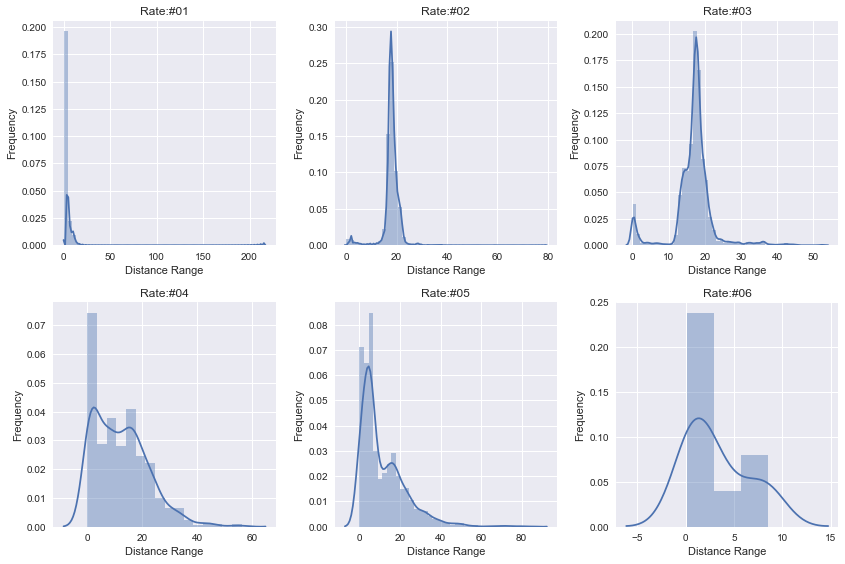

In [32]:
plt.rcParams['figure.figsize'] = 12,8
fig, ax = plt.subplots(nrows=2, ncols=3)
z=1
for x in range(2):
    for y in range(3):
        plt.tight_layout()
        print_distribution(ax[x,y], df,' rate_code',z,' trip_distance', 'Rate:#0'+str(z), 'Frequency', 'Distance Range')
        z+=1  

In [58]:
plt.rcParams['figure.figsize'] = 7, 4

Vamos olhar as distâncias médias agora:

In [39]:
for i in range(1,7):
    print('Distância Média com tarifa #' + str(i) +': ' +str(round(df.ix[df[' rate_code']==i, ' trip_distance'].mean(),2))+ ' milhas')

Distância Média com tarifa #1: 2.63 milhas
Distância Média com tarifa #2: 17.77 milhas
Distância Média com tarifa #3: 16.87 milhas
Distância Média com tarifa #4: 12.22 milhas
Distância Média com tarifa #5: 11.56 milhas
Distância Média com tarifa #6: 3.23 milhas


Vemos que as tarifas 2 e 3, que são as tarifas com origem ou destino em aeroportos são as que possuem as maiores distâncias médias, superando inclusive as tarifas 4 e 5 que são referentes a corridas fora da cidade. As tarifas 1 e 3 são usadas normalmente para corridas curtas. A 6 se refere a corridas em grupo.

#### Agora vamos dar uma olhada no tempo médio de viagem

In [50]:
for i in range(1,7):
    print('Tempo médio com tarifa #' + str(i) +': ' +str(round(df.ix[df[' rate_code']==i, ' trip_time_in_secs'].mean()/60,2))+ ' minutos')

Tempo médio com tarifa #1: 11.85 minutos
Tempo médio com tarifa #2: 40.92 minutos
Tempo médio com tarifa #3: 36.07 minutos
Tempo médio com tarifa #4: 25.02 minutos
Tempo médio com tarifa #5: 28.0 minutos
Tempo médio com tarifa #6: 25.85 minutos


Vamos ver agora como é a distribuição de corridas entre as diferentes taxas:

1    1222897
2      23581
3       1967
5       1613
4        607
6          9
Name:  rate_code, dtype: int64


''

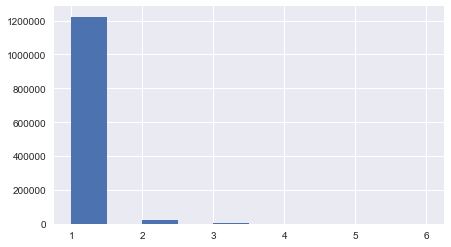

In [62]:
#Vou printar os valores antes do histograma para evidenciar a diferença entre as concentrações
print(df[' rate_code'].value_counts())
plt.hist(df[' rate_code'])
''

#### Aqui fica claro que a rate 1 tem concentração muito mais alta do que as outras

In [63]:
df[' pickup_datetime'].min()

'2013-08-05 00:19:00'

In [64]:
df[' pickup_datetime'].max()

'2013-08-31 23:59:59'

In [65]:
df[' dropoff_datetime'].min()

'2013-08-05 00:26:00'

In [66]:
df[' dropoff_datetime'].max()

'2013-09-01 00:52:00'

Todas as datas de embarque estão em Agosto de 2013, mas temos desembarque em Setembro. Para facilitar a análise, criarei colunas com mês, dia, hora e minuto tanto para embarque como para desembarque

In [67]:
df['pickup_month'] = df[' pickup_datetime'].str.slice(start=5, stop=7)
df['pickup_day'] = df[' pickup_datetime'].str.slice(start=8, stop=10)
df['pickup_hour'] = df[' pickup_datetime'].str.slice(start=11, stop=13)
df['pickup_minute'] = df[' pickup_datetime'].str.slice(start=14, stop=16)

In [68]:
df['dropoff_month'] = df[' dropoff_datetime'].str.slice(start=5, stop=7)
df['dropoff_day'] = df[' dropoff_datetime'].str.slice(start=8, stop=10)
df['dropoff_hour'] = df[' dropoff_datetime'].str.slice(start=11, stop=13)
df['dropoff_minute'] = df[' dropoff_datetime'].str.slice(start=14, stop=16)

In [70]:
df.columns

Index(['medallion', ' hack_license', ' rate_code', ' pickup_datetime',
       ' dropoff_datetime', ' passenger_count', ' trip_time_in_secs',
       ' trip_distance', ' pickup_longitude', ' pickup_latitude',
       ' dropoff_longitude', ' dropoff_latitude', 'pickup_month', 'pickup_day',
       'pickup_hour', 'pickup_minute', 'dropoff_month', 'dropoff_day',
       'dropoff_hour', 'dropoff_minute'],
      dtype='object')

In [71]:
df['speed_mph'] = df[' trip_distance']/(df[' trip_time_in_secs']/3600)

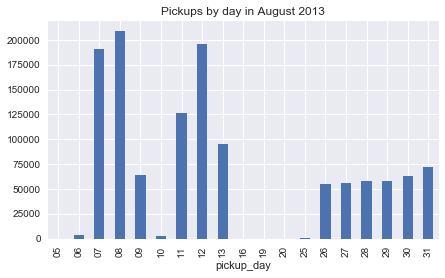

In [69]:
df.groupby(by=['pickup_day'])[' hack_license'].count().plot(kind='bar', title='Pickups by day in August 2013')

#### Claramente nós temos dias faltantes nos embarques, o que inviabiliza uma análise por dia do mês em Agosto

Mas vamos tentar uma análise por hora

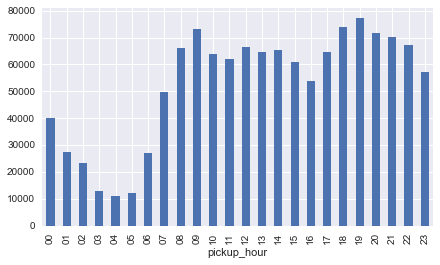

In [170]:
df.groupby(by=['pickup_hour'])[' hack_license'].count().plot(kind='bar', title='')

#### Ignorando o dia do mês e considerando apenas a hora, vemos uma curva que indica picos as 9h e às 19h, podendo significar a população indo e voltando do trabalho. Temos uma baixa na demanda, durante a madrugada.

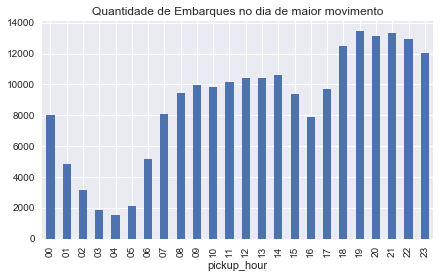

In [186]:
df.ix[df['pickup_day']=='08',:].groupby(by=['pickup_hour'])[' hack_license'].count().plot(kind='bar', title='Quantidade de Embarques no dia de maior movimento')

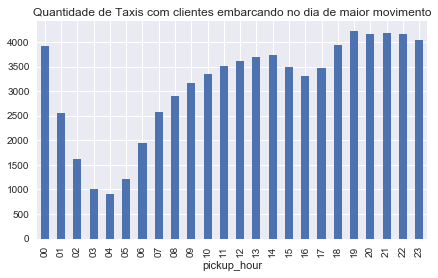

In [191]:
df.ix[df['pickup_day']=='08',:].groupby(by=['pickup_hour'])[' hack_license'].nunique().plot(kind='bar', title='Quantidade de Taxis com clientes embarcando no dia de maior movimento')

In [192]:
len(df[' hack_license'].unique())

26343

In [221]:
df.groupby(by=' hack_license').size().sort_values(ascending=False)

 hack_license
7B19DE6D4D54999531BEB27F758F71F6    354
CFCD208495D565EF66E7DFF9F98764DA    237
D85749E8852FCC66A990E40605607B2F    220
51C1BE97280A80EBFA8DAD34E1956CF6    217
                                   ... 
D2DE88FC7856A5F50C05E8D9B7A20838      1
5403C71B756A8EBC2C61ECC7389FFDF8      1
2E2F58DFB758E1F67FF58614D4A26847      1
0002555BBE359440D6CEB34B699D3932      1
dtype: int64

In [259]:
df.groupby(by=' hack_license').agg({'medallion':'count', ' trip_distance':'mean'}).reset_index().sort_values(by='medallion', ascending=False)

,hack_license,medallion,trip_distance
12605,7B19DE6D4D54999531BEB27F758F71F6,354,0.000565
21369,CFCD208495D565EF66E7DFF9F98764DA,237,3.586709
22280,D85749E8852FCC66A990E40605607B2F,220,3.094364
8340,51C1BE97280A80EBFA8DAD34E1956CF6,217,2.430507
...,...,...,...
10010,617B57B248AC7190A61C750DE26510D3,1,1.600000
10005,6172D972A1E14870B862F535B5763E57,1,2.000000
25089,F41A90B2CBABC15EC70D2E4F2F901FEB,1,4.300000
0,0002555BBE359440D6CEB34B699D3932,1,5.900000


In [260]:
df.groupby(by=' hack_license').agg({'medallion':'count', ' trip_distance':'mean'}).reset_index().sort_values(by=' trip_distance', ascending=True)

,hack_license,medallion,trip_distance
18475,B39EC727955CF8714738DDE8A4707E9B,1,0.000000e+00
17983,AF21D0C97DB2E27E13572CBF59EB343D,20,0.000000e+00
15888,9B257FC037652A68D1404A5F7C206A57,1,0.000000e+00
11817,735B90B4568125ED6C3F678819B6E058,6,0.000000e+00
...,...,...,...
19324,BC0B2E4616DF627759FA42A90A2CAD97,17,4.706393e+05
1130,0B21B07994F53C937E2687A81488A3C5,31,6.929110e+05
22151,D71585382E18358678091C2B98C548F0,12,9.833373e+05
22021,D5EDBD218A9831DE3ECC458B8E2DC608,12,1.562379e+06


In [262]:
df.ix[df[' hack_license']=='7B19DE6D4D54999531BEB27F758F71F6']

,medallion,hack_license,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist_range
369311,63C3BB163F22D850E726CBCA4D8258C3,7B19DE6D4D54999531BEB27F758F71F6,1,2013-08-07 09:17:00,2013-08-07 09:19:00,2,120,0.0,0.000000,0.000000,0.000000,0.000000,0.5
370860,54E164D9BEC68DE1148F87110F405DE0,7B19DE6D4D54999531BEB27F758F71F6,1,2013-08-07 10:48:00,2013-08-07 10:50:00,1,120,0.0,-73.937340,40.758259,-73.937325,40.758251,0.5
371439,3FE993A83124A987A87098160981D3B6,7B19DE6D4D54999531BEB27F758F71F6,1,2013-08-06 10:08:00,2013-08-06 10:08:00,2,0,0.0,0.000000,0.000000,0.000000,0.000000,0.5
372784,3FE993A83124A987A87098160981D3B6,7B19DE6D4D54999531BEB27F758F71F6,1,2013-08-07 02:10:00,2013-08-07 02:11:00,1,60,0.0,-73.937508,40.758263,-73.937508,40.758266,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251842,1560E7C1453E7996A61C96B7A8824EFE,7B19DE6D4D54999531BEB27F758F71F6,1,2013-08-13 11:38:00,2013-08-13 11:43:00,1,300,0.0,-73.937813,40.758240,-73.937813,40.758236,0.5
1251941,C1774E2BF1CB7962683997AD39427D25,7B19DE6D4D54999531BEB27F758F71F6,1,2013-08-13 13:20:00,2013-08-13 13:20:00,1,0,0.0,-73.937393,40.758102,-73.938210,40.758244,0.5
1254924,937A41116FCDEBA535FC3FA0B2965043,7B19DE6D4D54999531BEB27F758F71F6,1,2013-08-13 14:07:00,2013-08-13 14:56:00,1,2940,0.0,0.000000,0.000000,0.000000,0.000000,0.5
1258078,937A41116FCDEBA535FC3FA0B2965043,7B19DE6D4D54999531BEB27F758F71F6,1,2013-08-13 13:34:00,2013-08-13 13:34:00,1,0,0.0,0.000000,0.000000,0.000000,0.000000,0.5


In [267]:
df.ix[(df[' pickup_latitude']==0) & (df[' pickup_longitude']!=0)]

,medallion,hack_license,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist_range
615025,8D1BB91A5D5D7BE4BEDFF23F2DEFD026,4AF51CFB6625EF4B2F3D28F887831D0C,1,2013-08-06 20:59:00,2013-08-06 21:21:00,5,1320,6.09,-73.986565,0.0,-74.011543,40.708885,6.5
723667,566284B58F01B2795826A1EB2D3F0878,923F7DB16E1F81101C4C45A5918A2A2F,1,2013-08-08 09:21:00,2013-08-08 09:30:00,1,540,1.60,-73.966789,0.0,-73.979446,40.756065,2.0
756784,4EF7FFB140F99C849410B914939B4949,6826C6F899BC8E147099C30C1BAA9B8F,1,2013-08-08 12:50:00,2013-08-08 13:07:00,6,1020,7.16,-5.576667,0.0,0.000000,40.762001,7.5
911653,8C888A90058235542F37DFB4E8232E8A,DED82821229975847692EAD33528A8F1,1,2013-08-09 00:32:00,2013-08-09 00:45:00,1,780,3.20,-0.030000,0.0,-73.989204,40.748058,4.0
1178549,8C888A90058235542F37DFB4E8232E8A,DED82821229975847692EAD33528A8F1,1,2013-08-13 02:28:00,2013-08-13 02:41:00,1,780,5.11,-0.001667,0.0,-73.938103,40.758476,5.5


In [268]:
len(df.ix[(df[' trip_distance']==0)])

8699

In [271]:
df.ix[(df[' trip_distance']==0) & (df[' trip_time_in_secs']!=0)].sort(columns=' trip_time_in_secs', ascending=False)

,medallion,hack_license,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist_range
148177,B30FB8B1B1878DFDC6688FAAAA81BF89,29888243C6F4D6A960B334855C53121B,5,2013-08-31 08:43:25,2013-08-31 09:27:06,1,4287947,0.0,-73.772118,41.030685,-73.777824,41.029865,0.5
301387,E11DF7327D10A3BC3C93A0E3A7F4DE7A,F4C08E5B30603FB8148A898BB8D30DA0,1,2013-08-31 23:45:44,2013-09-01 00:07:00,1,4283244,0.0,-73.977905,40.725559,-74.008278,40.736591,0.5
597506,1560E7C1453E7996A61C96B7A8824EFE,7B19DE6D4D54999531BEB27F758F71F6,1,2013-08-09 14:05:00,2013-08-10 10:59:00,1,75240,0.0,0.000000,0.000000,0.000000,0.000000,0.5
1239442,D39704A62CF63852EE31C1B66275E75D,7B19DE6D4D54999531BEB27F758F71F6,1,2013-08-12 17:14:00,2013-08-13 13:07:00,1,71580,0.0,0.000000,0.000000,0.000000,0.000000,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
473027,156DF7A073DD7F63E03CD4D1792F0B29,CFC77A93E69B09CBCE880E832080473E,1,2013-08-11 17:52:10,2013-08-11 17:52:00,6,-10,0.0,0.000000,0.000000,0.000000,0.000000,0.5
910717,2448B617F670608F520543E8137F0A53,B81298D7AFE3F080D8F9E03BA38CAE71,1,2013-08-09 00:24:10,2013-08-09 00:24:00,5,-10,0.0,-73.954750,40.734509,0.000000,0.000000,0.5
686077,14B6352E4AC7C4732A518085AF4253DD,A19CA52E8D354018EF2EE45EAF62F8EB,1,2013-08-07 23:34:10,2013-08-07 23:34:00,1,-10,0.0,0.000000,0.000000,0.000000,0.000000,0.5
997457,8E9B734B07B3F6DF25B6D910CC1C327B,AEABEA26F696B3993614046AA60CBFFB,1,2013-08-12 06:01:10,2013-08-12 06:01:00,1,-10,0.0,0.000000,0.000000,0.000000,0.000000,0.5
